# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Intro to ARIMA Model
Week 12 | Lesson 2.1





### LEARNING OBJECTIVES
*After this lesson, you will be able to:*
- Model and predict from time series data using AR, ARMA or ARIMA models
- Code those models in `statsmodels`




### LESSON GUIDE
| TIMING  | TYPE  | TOPIC  |
|:-:|---|---|
| 5 min  | [Opening](#opening)  | What are Time Series Models?  |
| 15 min  | [Introduction](#intro-tsmprops)  | Properties of Time Series Models  |
| 10 min  | [Exercise](#exercise)  | Investigating Timeseries Data using Google  |
| 5 min  | [Introduction](#intro-ar)  | AR Models  |
| 5 min  | [Introduction](#intro-ma)  | MA Models  |
| 5 min  | [Introduction](#intro-arma)  | ARMA Models  |
| 5 min  | [Introduction](#intro-arima)  | ARIMA Models  |
| 15 min  | [Demo/Codealong](#demo1)  | Demo/Codealong: Timeseries EDA in `statsmodels`  |
| 15 min  | [Demo/Codealong](#demo2)  | Demo/Codealong: AR, MA and ARMA models in `statsmodels`  |
| 15 min  | [Demo/Codealong](#demo2)  | Demo/Codealong: ARIMA models in `statsmodels`  |
| 5 min  | [Conclusion](#conclusion)  | Recap  |

---


<a name="opening"></a>
## Opening: What are Time Series Models? (5 min)

- In the previous lesson, we explored time series data and common statistics for time series analysis.


- Let's build on that to *predict* time series data.


### Time series models

- Time series models predict a future value in the time series. Like other predictive models, we will use prior history to predict the future. Unlike previous models, we will use the _outcome_ variables from earlier in time as the _inputs_ for prediction.

- As with the modeling you're used to, we will have to evaluate different models to ensure we have chosen the best one.

- So we will want to evaluate on _test data_ to ensure our model performs well on unseen data.



<a name="intro-tsmprops"></a>
## Introduction: Properties of Time Series Models (15 min)

### Training and test sets

Since there is a time component to our data, we **cannot choose training and test examples at random.** As we are attempting to predict _a sequence of future values_, we must train on values from earlier (in time) in our data and then test our values at the end of the period.



### Properties for time-series prediction
In our last class we saw a few statistics for analyzing time series. We looked at moving averages to evaluate the local behavior of the time series.

**Check:** What's a moving average?

> Answer: A _moving average_ is an average of _k_ surrounding data points in time.

 ![](./assets/images/single_moving_avg_fit.gif)


We also looked at autocorrelation to compute the relationship of the data with prior values.

**Check:** What's autocorrelation?

> _Autocorrelation_ is how correlated a variable is with itself. Specifically, how related variables from earlier in time are with variables from later in time. Note the need for a mean value...

${\Huge R(k) = \frac{\operatorname{E}[(X_{t} - \mu)(X_{t-k} - \mu)]}{\sigma^2}}^*$


### Stationarity

Many models make an assumption of _stationarity_: assuming the mean and variance of our values is the same throughout.

This means that while the values (of sales, for example) may shift up and down over time, the _mean value_ of sales is constant, as well as the variance.




As always, these assumptions may not represent real-world data. For example, typical stock market performance is not stationary. In this plot of Dow Jones performance since 1986, the mean is clearly increasing over time.

![](./assets/images/dow-jones.png)

We can preprocess our data to achieve stationarity. Two common methods are _detrending_ and _differencing_.

_Detrending_ removes major trends in our data. The simplest way is to fit a line to the trend, then make a new series of the difference between the line and the true series. For example, in iPhone google searches, there is a clear upward (non-stationary) trend.

If we fit a line to this data first, we can create a new series that is the difference between the true number of searches and the predicted searches. We can then fit a time-series model to this difference.

![](./assets/images/google-iphone.png)

Below are U.S. housing prices over time demonstrating an upward trend. This makes the time-series non-stationary, as the mean home price is increasing. The line fit through it represents the trend.

The bottom figure is the "detrended" data, where each data point is transformed by subtracting off the value of the trend line at that point This data now has a fixed mean and may be easier to model. This is similar to mean-scaling our features in earlier models with `StandardScaler`.

![](./assets/images/detrend.gif)



         week  drone_racing_interest
0  2014-11-09                      2
1  2014-11-16                      2
2  2014-11-23                      4
3  2014-11-30                      6
4  2014-12-07                      7


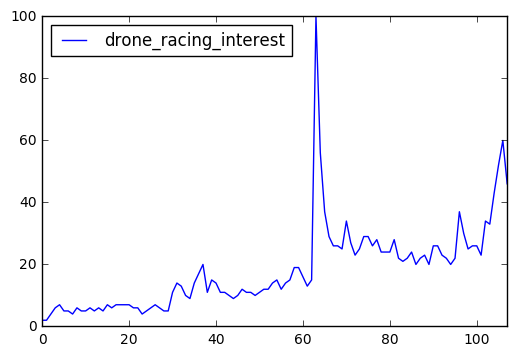

In [6]:
## Simple detrending example
import pandas as pd
df = pd.read_csv('/Users/macbook/GA-DSI/curriculum/week-12/2.1-arima/assets/datasets/gt_drone_racing.csv', header=1)
df.columns = ['week','drone_racing_interest']
print df.head()

df.plot();

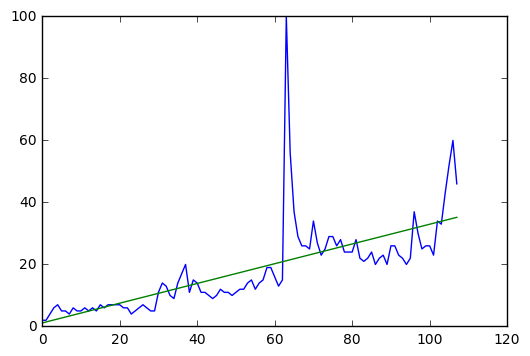

In [5]:
## Fit a trend line
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
coefs = np.polyfit(df.index, df.drone_racing_interest,1)
lineFunction = np.poly1d(coefs)
plt.plot(df.index, df.drone_racing_interest, df.index, lineFunction(df.index))

## Detrend: in its simplest form, literally subtract the trend line
#plt.plot(df.index, df.drone_racing_interest - lineFunction(df.index))

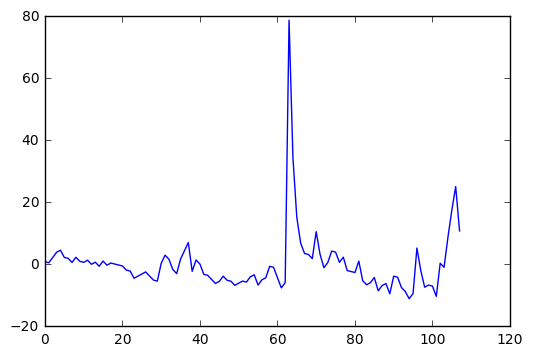

In [7]:
## There are helper functions to do this too, e.g.:

import scipy.signal
ffty=scipy.signal.detrend(df.drone_racing_interest.values)
plt.plot(df.index, ffty)

- A related method is _differencing_.

- Instead of predicting the (non-stationary) series, we can predict the difference between two consecutive values.

- **ARIMA** models incorporate this approach.

> Check: with Pandas, what's an easy way to find the difference between two points in time?


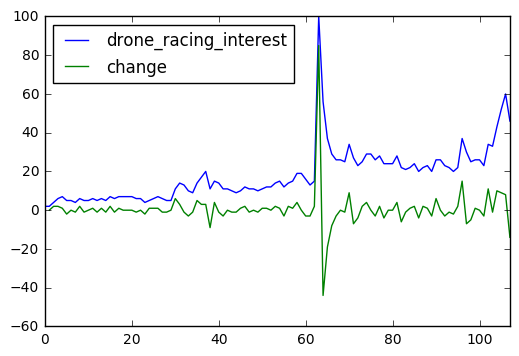

In [8]:
# the .diff() method

df['change'] = df.drone_racing_interest.diff(1);
df.plot()

<a name="exercise"></a>
## Exercise: Investigating Timeseries Data using Google (10 mins)

Non-stationary data is the most common type of data, since almost any interesting dataset is non-stationary. Can you find datasets that are stationary?

Open trends.google.com and investigate some time series visualizations of google searches. Also check out googletrends.github.io/data/.

> Check: Propose topics that you think would have a stationary time series. Was your assumption correct?



# Timeseries Modeling

- In the rest of this lesson, we are going to build up to the **ARIMA** time series model.


- This combines the ideas of differencing and two models we will see below: **AR**, or autoregressive, models and **MA**, or moving average, models.



<a name="intro-ar"></a>
## AR Models (5 min)

- **Autoregressive (AR) models** use data from previous time-points to predict the next time-point


- Structurally these are just like linear regression models, except as input we take some previous outcome.


- Typically, AR models are denoted AR(p), where _p_ indicates the number of previous time points to incorporate. AR(1) is the most common.





- Similar to standard regression, we'll learn regression coefficients, where the inputs or features are the previous _p_ values: so we learn _p_ coefficients.

$$y_i = c + \beta_1 * y_{i-1} + \beta_2 * y_{i-2}\ +\ ...\ +\ \beta_p * y_{i-p}\ +\ \epsilon$$

- As with standard regression, our model assumes that each outcome variable is a linear combination of the inputs and a random error term.  



- For AR(1) models, we will learn a _single_ coefficient. This coefficient will tell us the relationship between the previous value and the next one. A value > 1 would indicate a growth over previous values.

> Check: if $\beta_1$ in an AR(1) model is > 1, is it modeling stationary data?

- Values above 1 and below -1 represent increasing and decreasing patterns, respectively.

- Recall, _autocorrelation_ is the correlation of a value with itself. We compute correlation with values _lagged_ behind. A model with high-correlation implies that the data is highly dependent on previous values and an autoregressive model would perform well.

- Autoregressive models are useful for learning falls or rises in our series. Typically, this model type is useful for small-scale trends, such as an increase in demand that will gradually increase the series.

- As with other linear models, interpretation becomes more complex as we add more factors; as we go from AR(1) to AR(2) we begin to have significant _multi-collinearity_.

> **Check:** If we observe an autocorrelation near 1 for lag 1, what do we expect the single coefficient in an AR(1) model to be: > 1, between 0 and 1 or < 1? What if the autocorrelation is 0?

- If the data are non-stationary, it may be > 1 -- our data may be increasing over time


- If the data are stationary, it will be between 0 and 1 -- in fact the coefficient and lag 1 autocorrelation should be the same


- If the coefficient is around 0, we should just predict a single value (intercept) throughout

<a name="intro-ma"></a>
## MA Models (5 min)

**Moving average models** take previous _error terms_ as inputs. We attempt to predict the next value based on the overall average and how incorrect our previous predictions were. This is useful for modeling a sudden occurrence - like something going out of stock affecting sales or a sudden rise in popularity.

As in autoregressive models, we have an order term, _q_, and we refer to our model as _MA(q)_.  This moving average model is dependent on the last _q_ errors. If we have a time series of sales per week, $y_i$, we can regress each $y_i$ from the last _q_ error terms.

$${\Large y_i = mean + \beta_1 * \epsilon_i + ... \beta_q * \epsilon_q}$$

But we don't have the errors terms when we start - where do they come from?

This requires a more complex fitting procedure than we have seen, where we iteratively fit a model (perhaps with random error terms), compute the errors and then refit, over and over again.

We'll include the mean of the time series and that is why we call this a moving average, as we assume the model takes the mean value of a series and randomly jumps around it.



With this model, we'll learn _q_ coefficients. In an MA(1) model, we learn one coefficient where this value indicates the impact of our previous error on our next prediction.

**Check:** What are the AR and MA terms, and how are they defined?

<a name="intro-arma"></a>
## ARMA Models (5 min)

Another stepping stone to **ARIMA** models are **ARMA** models.

_ARMA_ models combine the autoregressive models and moving averages. We specify two model settings `p` and `q`, which correspond to combining an AR(p) model with an MA(q) model.

An ARMA(p, q) model is simply a combination (sum) of an AR(p) and MA(q) model.

Autoregressive models slowly incorporate changes in preferences, tastes, and patterns. Moving average models base their prediction not on the prior value but the prior error, allowing us to correct sudden changes based on random events - supply, popularity spikes, etc.


<a name="intro-arima"></a>
## ARIMA Models (5 min)

**ARIMA** is an Autoregressive Integrated Moving Average model.

In this model, we learn an ARMA(p, q) to predict not the value of the series, but the difference of the two series.

Recall the pandas `diff` function. This computes the difference between two consecutive values. In an ARIMA model, we attempt to predict this difference instead of the actual values.

$$\Huge{y_t - y_{(t-1)} = ARMA(p, q)}$$

This handles the stationarity assumption. Instead of detrending or differencing explicitly, the model does this by adding the Integration term.

An ARIMA model has three parameters and is specified ARIMA(p, d, q), where:

- _p_ is the order of the autoregressive component
- _q_ is the order of the moving average component
- _d_ is the degree of differencing. 

$$\Large{y_t - y_{(t-1)} = ARMA(p, q)}$$

In the above, we set _d = 1_ . For a higher value of _d_, for example, d=2, the model would be:

                         diff(diff(y)) = ARMA(p, q)

We would apply the `diff` function _d_ times.




Unlike ARMA models, ARIMA does not rely on the underlying series being stationary.

The differencing operation can _convert_ the series to one that is stationary. Instead of attempting to predict the values over time, our predicted series is the _difference_ in values over time.

Since ARIMA models automatically include differencing, we can (try to) use this on a broader set of data without assumptions of a constant mean.

To recap...

- AR: AutoRegressive process
- MA: Moving Average process
- ARMA: Model using a combination of Autoregressive and Moving Average terms
- ARIMA: ARMA model with an added term describing differencing order

<a name="demo1"></a>
## Demo: Time Series EDA in `statsmodels` (15 mins)

Let's revisit the Rossmann sales data.  This dataset has sales data for sales at every Rossmann store for a 3-year period, as well as indicators of holidays and basic store information.

We previously plotted sales data at a store to see how sales changed over time. And we computed autocorrelation for the data at varying lag periods. This helped us identify which previous timepoints might be predictive of future data: the previous day? week? month?


/Users/macbook/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


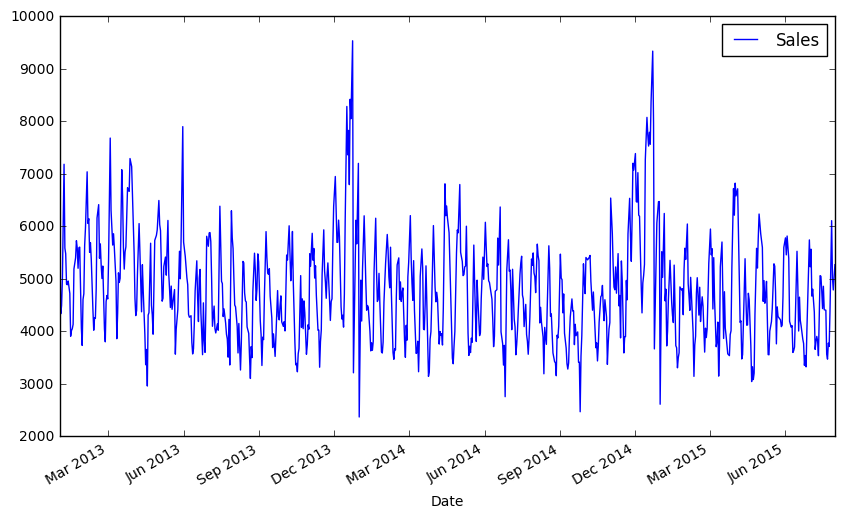

In [9]:
%matplotlib inline

import pandas as pd
import matplotlib as plt
plt.rcParams['figure.figsize'] = (10, 6)

# Load the data and set the DateTime index
data = pd.read_csv('/Users/macbook/GA-DSI/curriculum/week-12/2.1-arima/assets/datasets/rossmann.csv', skipinitialspace=True)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Filter to Store 1
store1_data = data[data.Store == 1]
# Filter to open days
store1_open_data = store1_data[store1_data.Open==1]
# Plot the sales over time
store1_open_data[['Sales']].plot()


In [10]:
# Compute the autocorrelation of Sales in Store 1 for lag 1 and 2. 
# Will we be able to use a predictive model - particularly an autoregressive one?

print store1_data.Sales.autocorr(lag=1) # -0.12
print store1_data.Sales.autocorr(lag=2) # -0.03



-0.127325143391
-0.0347871557079


- We see some minimal correlation in time, implying an AR model can be useful. 

 
- An easier way to diagnose this may be to plot many autocorrelations at once.



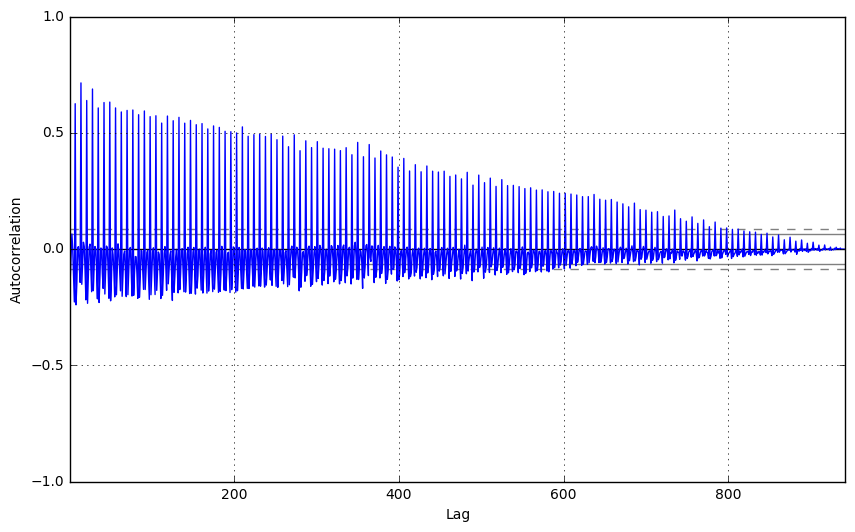

In [11]:
# What does the resulting plot show?
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(store1_data.Sales);

# This shows a typical pattern of an autocorrelation plot - it should decrease to 0 as lag increases! 
# However, it's hard to observe exactly what the values are.

Let's plot the ACF at more detail using `statsmodels`.



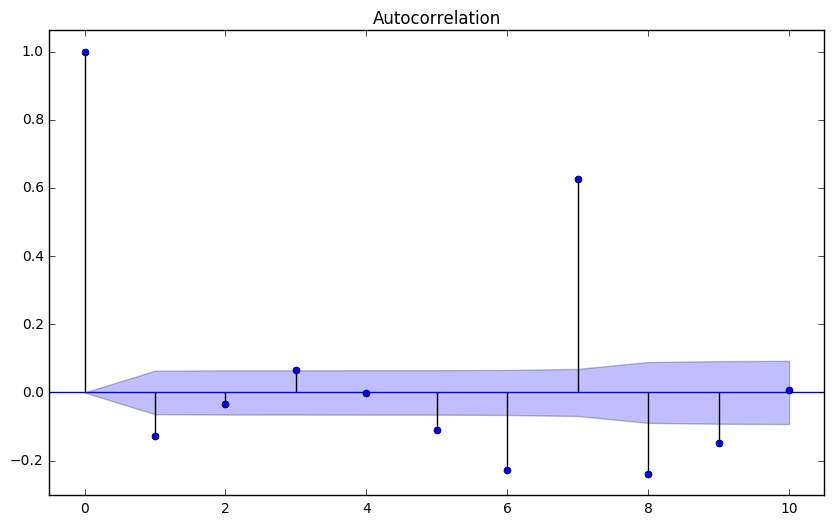

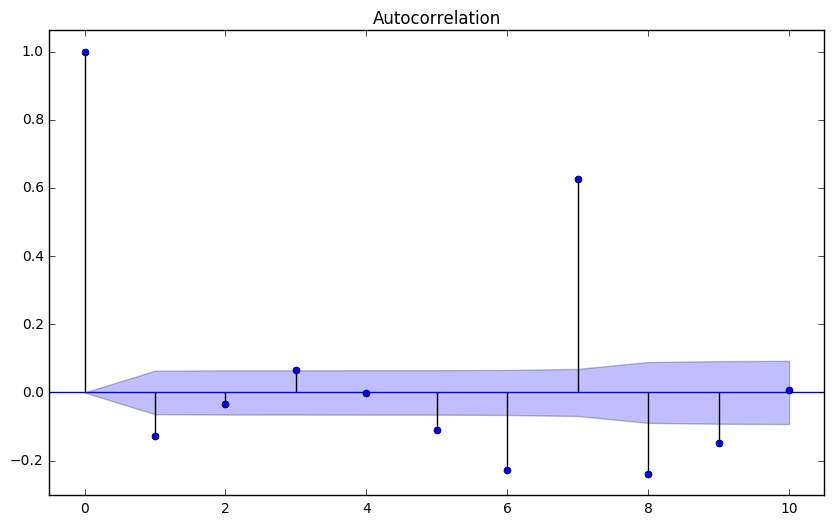

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(store1_data.Sales, lags=10)

Here we observe autocorrelation at 10 lag values. 1 and 2 are what we saw before. This implies a small, but limited impact from the previous few values, suggesting that an autoregressive model might be useful.

**Check**: We also observe a larger spike at 7 - what does that mean?

> That's the amount of days in a week!

If we observed a handful of randomly distributed spikes - that would imply a MA model may be useful. This is because those random spikes suggest that at some point in time, something changed in the world and all values are shifted up or down from there in a fixed way.

That may be the case here, but if we expand the window we can see that the spikes occur regularly at 7 days windows. This means we have a weekly cycle!



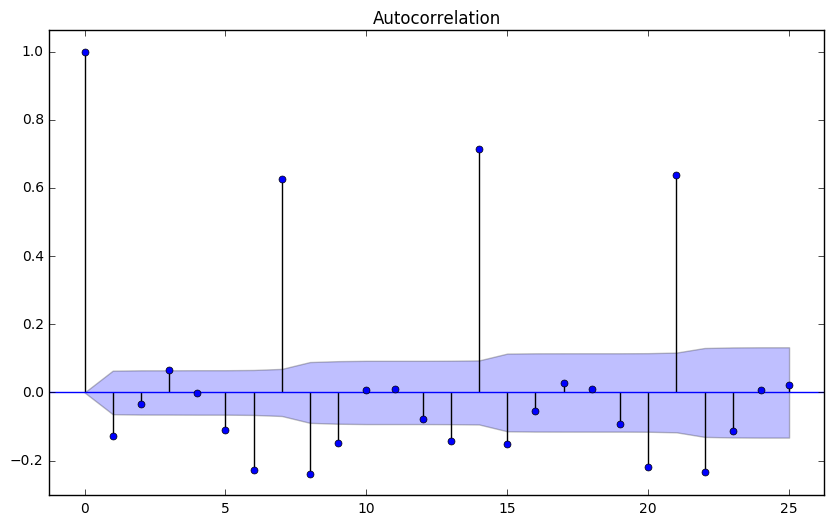

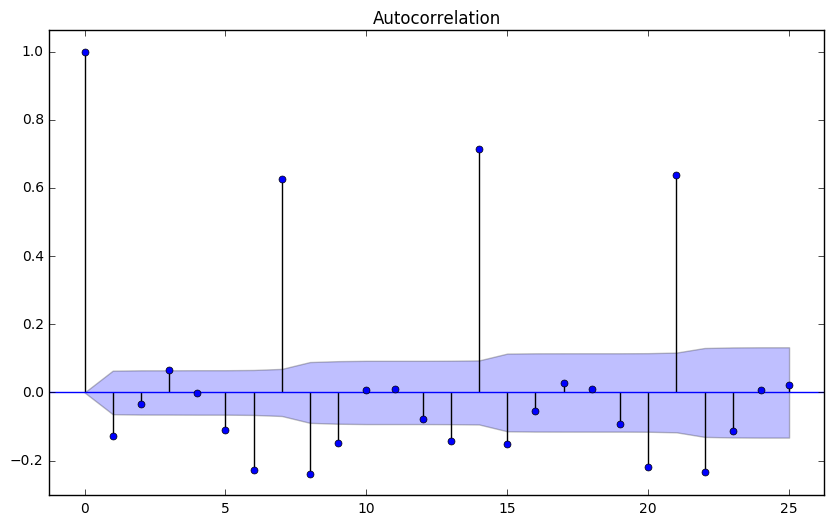

In [13]:
plot_acf(store1_data.Sales, lags=25)


<a name="demo2"></a>
## Demo: AR, MA and ARMA models in `statsmodels` (15 mins)

To explore AR and ARMA models, we will use `sm.tsa.ARMA`. We can train an autoregressive model by turning off the moving average component (setting q = 0).


In [14]:
from statsmodels.tsa.arima_model import ARMA

store1_sales_data = store1_open_data[['Sales']].astype(float)
model = ARMA(store1_sales_data, (1, 0)).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 0)   Log Likelihood               -6267.326
Method:                       css-mle   S.D. of innovations            739.079
Date:                Tue, 06 Dec 2016   AIC                          12540.651
Time:                        11:33:17   BIC                          12554.633
Sample:                    07-31-2015   HQIC                         12546.029
                         - 01-02-2013                                         
===============================================================================
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        4762.6173     82.986     57.391      0.000      4599.969  4925.266
ar.L1.Sales     0.6822      0.026     26.122      0.000         0.631     0.733
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4659           +0.0000j            1.4659            0.0000
-----------------------------------------------------------------------------
"""

By passing the `(1, 0)` in the second argument, we are fitting an ARMA model as ARMA(p=1, q=1). Remember, an ARMA(p, q) model is AR(p) + MA(q). This means that an ARMA(1, 0) is the same as an AR(1) model.

In this AR(1) model we learn an intercept value, or base sales values. Additionally, we learn a coefficient that tells us how to include the last sales values. In this case, we take the intercept of ~4700 and add in the previous months sales * 0.68.

Note the coefficient here does not match the lag 1 autocorrelation - implying the the data is not stationary.

We can learn an AR(2) model, which regresses each sales value on the last two, with the following:



In [15]:
model = ARMA(store1_sales_data, (2, 0)).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(2, 0)   Log Likelihood               -6267.032
Method:                       css-mle   S.D. of innovations            738.800
Date:                Tue, 06 Dec 2016   AIC                          12542.063
Time:                        11:33:21   BIC                          12560.705
Sample:                    07-31-2015   HQIC                         12549.233
                         - 01-02-2013                                         
===============================================================================
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        4762.9851     85.262     55.863      0.000      4595.875  4930.095
ar.L1.Sales     0.6634      0.036     18.537      0.000         0.593     0.734
ar.L2.Sales     0.0274      0.036      0.767      0.443        -0.043     0.098
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4235           +0.0000j            1.4235            0.0000
AR.2          -25.5915           +0.0000j           25.5915            0.5000
-----------------------------------------------------------------------------
"""

Here we learn two coefficients, which tells us the effect of the last two sales values on current sales. To make a sales prediction for a future month, we would combine the last two months of sales with the weights or coefficients learned.

While this model may be able to better model the series, it may be more difficult to interpret.

To start to diagnose the model, we want to look at the _residuals_.

**Check:** What are residuals? In linear regression, what did we expect of residuals?





_Residuals_ are the errors of the model, or a measure of how off our prior predictions were.

What we ideally want are randomly distributed errors that are fairly small. If the errors are large then clearly that would be problematic. If the errors have a pattern, particularly over time, then we have overlooked something in the model or certain periods of time are different than the rest of the dataset.

We can plot the residuals as below:

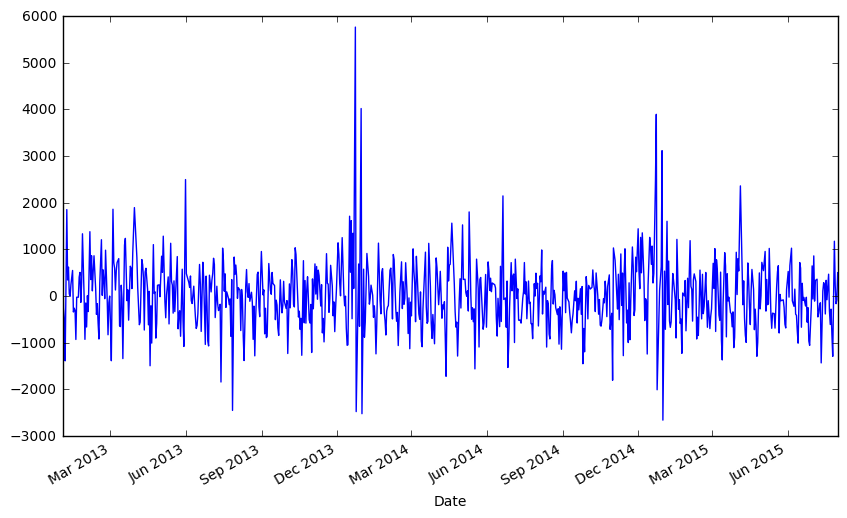

In [16]:
model.resid.plot()

Here we saw large spikes at the end of each year, indicating that our model does not account for holiday spikes. Of course, our models are only related to the last few values in the time series, and don't take into account the longer seasonal pattern.

We can also plot the autocorrelations of the residuals. In an ideal model, these would all nearly be 0 and hopefully random.



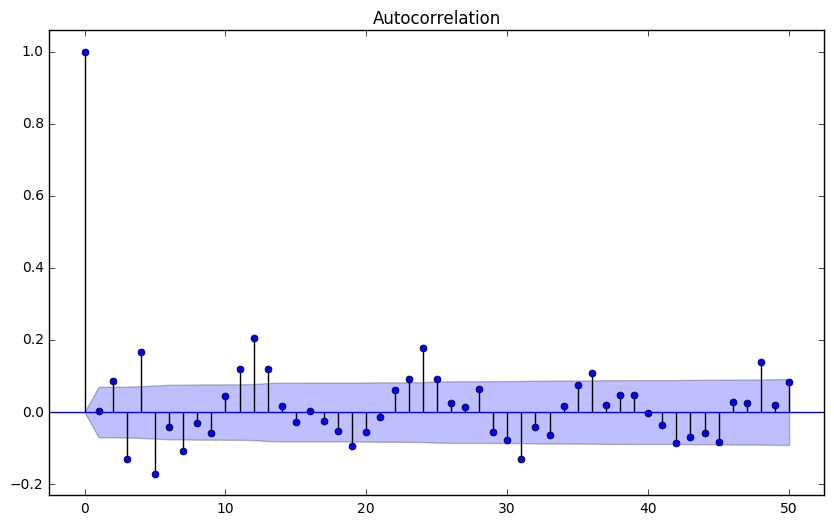

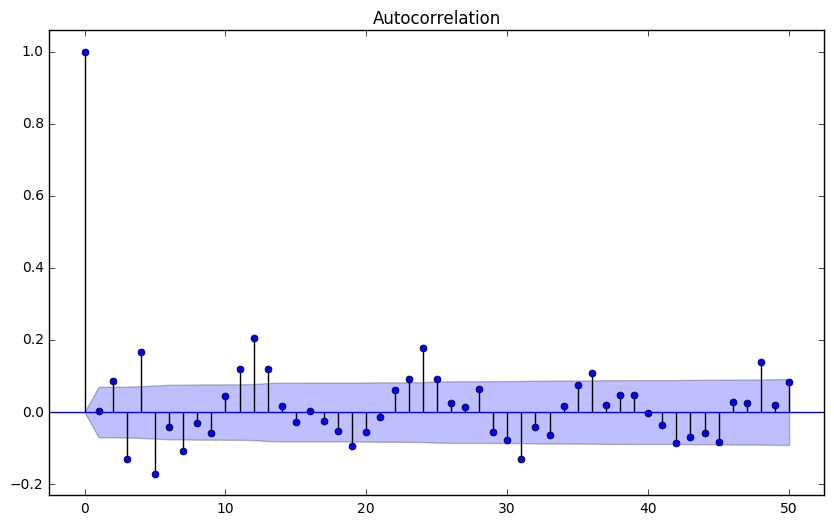

In [17]:
plot_acf(model.resid, lags=50)

This aspect is also troubling - the autocorrelation plot shows a clear pattern where errors are increasing and decreasing every week.

To expand this AR model to a ARMA model, we can include the moving average component as well.



In [18]:
model = ARMA(store1_sales_data, (1, 1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 1)   Log Likelihood               -6267.111
Method:                       css-mle   S.D. of innovations            738.876
Date:                Tue, 06 Dec 2016   AIC                          12542.222
Time:                        11:33:35   BIC                          12560.865
Sample:                    07-31-2015   HQIC                         12549.392
                         - 01-02-2013                                         
===============================================================================
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        4762.6891     84.702     56.229      0.000      4596.676  4928.702
ar.L1.Sales     0.6979      0.035     20.095      0.000         0.630     0.766
ma.L1.Sales    -0.0294      0.045     -0.654      0.514        -0.118     0.059
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4328           +0.0000j            1.4328            0.0000
MA.1           34.0018           +0.0000j           34.0018            0.0000
-----------------------------------------------------------------------------
"""

Now we learn two coefficients, one for the AR(1) component and one for the MA(1)

**Check:** Take a moment to look at the coefficients and offer an interpretation.


Remember this is an AR(1) + MA(1) model. So the AR coefficient represents dependency on the last value and the MA component represents any spikes independent of the last value.

The coefficients here are 0.69 for the AR component and -0.03 for the MA component. The AR coefficient is the same as before (decreasing values) and the MA component is fairly small (which we expected from the autocorrelation plots, which didn't imply we frequently needed sharp corrections to errors).


<a name="demo3"></a>
## Demo: ARIMA models in `statsmodels` (15 mins)

To train an ARIMA model in `statsmodels`, we can change the `ARMA` model to `ARIMA` and provide the differencing parameter. To start, we can see that we can train an ARMA(2,2) model by training an ARIMA(2, 0, 2) model.

In [28]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(store1_sales_data, (2, 0, 2)).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(2, 2)   Log Likelihood               -6243.725
Method:                       css-mle   S.D. of innovations            716.957
Date:                Tue, 06 Dec 2016   AIC                          12499.449
Time:                        12:16:22   BIC                          12527.413
Sample:                    07-31-2015   HQIC                         12510.204
                         - 01-02-2013                                         
===============================================================================
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        4760.9542     75.652     62.933      0.000      4612.680  4909.229
ar.L1.Sales    -0.2277      0.056     -4.064      0.000        -0.338    -0.118
ar.L2.Sales     0.4689      0.057      8.271      0.000         0.358     0.580
ma.L1.Sales     0.9626      0.062     15.638      0.000         0.842     1.083
ma.L2.Sales     0.2797      0.061      4.613      0.000         0.161     0.399
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2376           +0.0000j            1.2376            0.5000
AR.2            1.7233           +0.0000j            1.7233            0.0000
MA.1           -1.7208           -0.7837j            1.8908           -0.4320
MA.2           -1.7208           +0.7837j            1.8908            0.4320
-----------------------------------------------------------------------------
"""

We can see that this model in fact simplifies automatically to an ARMA model.  If we change the differencing parameter to 1, we train an ARIMA(2, 1, 2). This predicts the difference of the series.



In [29]:
model = ARIMA(store1_sales_data, (2, 1, 2)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -6247.179
Method:                       css-mle   S.D. of innovations            725.652
Date:                Tue, 06 Dec 2016   AIC                          12506.358
Time:                        12:16:29   BIC                          12534.314
Sample:                    07-30-2015   HQIC                         12517.111
                         - 01-02-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             0.5079      0.387      1.314      0.189        -0.250     1.266
ar.L1.D.Sales    -0.1820      0.050     -3.661      0.000        -0.279    -0.085
ar.L2.D.Sales     0.6469      0.035     18.602      0.000         0.579     0.715
ma.L1.D.Sales    -0.1858      0.052     -3.569      0.000        -0.288    -0.084
ma.L2.D.Sales    -0.8142      0.052    -15.659      0.000        -0.916    -0.712
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1106           +0.0000j            1.1106            0.5000
AR.2            1.3920           +0.0000j            1.3920            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.2282           +0.0000j            1.2282            0.5000
-----------------------------------------------------------------------------
"""

For a moment, let's remove the moving average component since it wasn't particularly useful before.



In [30]:
model = ARIMA(store1_sales_data, (1, 1, 0)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -6313.616
Method:                       css-mle   S.D. of innovations            792.680
Date:                Tue, 06 Dec 2016   AIC                          12633.233
Time:                        12:16:38   BIC                          12647.211
Sample:                    07-30-2015   HQIC                         12638.609
                         - 01-02-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             0.1765     24.028      0.007      0.994       -46.917    47.270
ar.L1.D.Sales    -0.1815      0.035     -5.150      0.000        -0.251    -0.112
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -5.5103           +0.0000j            5.5103            0.5000
-----------------------------------------------------------------------------
"""

This is now an AR(1) model on the differenced data.  We learn a single coefficient of -.18.

**Check:** Does this match the lag 1 autocorrelation of the differenced series? Is the data stationary? Why or why not? 


-0.181441014476


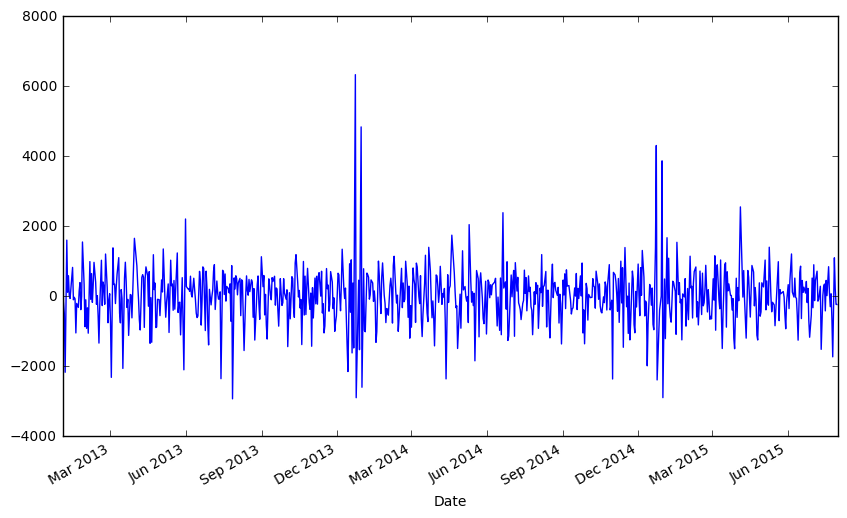

In [22]:
# We can compute the lag 1 auto correlation of the difference series and see if they match!

print store1_sales_data.Sales.diff(1).autocorr(1) #-0.181
store1_sales_data.Sales.diff(1).plot()

**Check**: Notice this looks generally true, but the variance is not constant. Why not?

From our models, we can also plot future predictions and compare them with the true series. To compare our forecast with the true values, we can use the `plot_predict` function.

We can compare the last 50 days of true values and predictions as values:

781


/Users/macbook/anaconda/lib/python2.7/site-packages/statsmodels/tsa/arima_model.py:1847: FutureWarning: TimeSeries is deprecated. Please use Series
  forecast = TimeSeries(forecast, index=self.data.predict_dates)


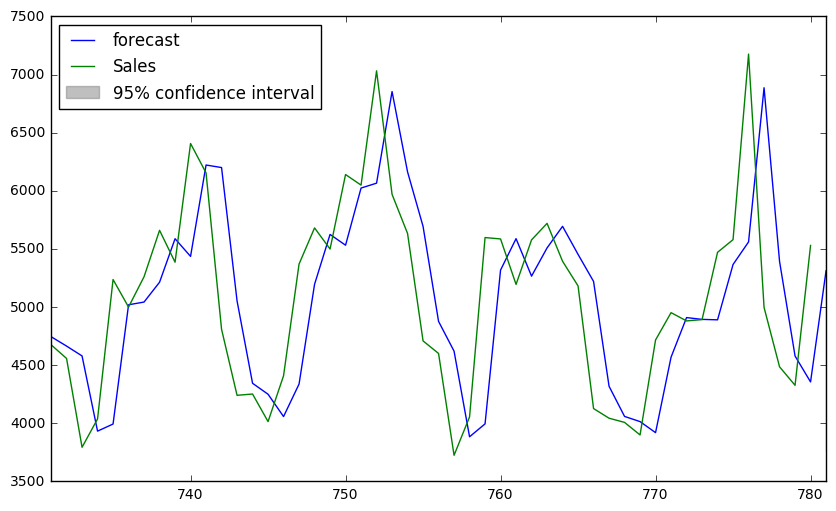

In [23]:
print len(store1_sales_data)
model.plot_predict(731, 781);

This function takes two arguments which are the start and end index of the dataframe to plot. Here, we are plotting the last 50 values.

To plot earlier values, with our predictions extended out, we do the following. This plots true values in 2014, and our predictions going back 200 days from our last prediction date of 2015-07-30.


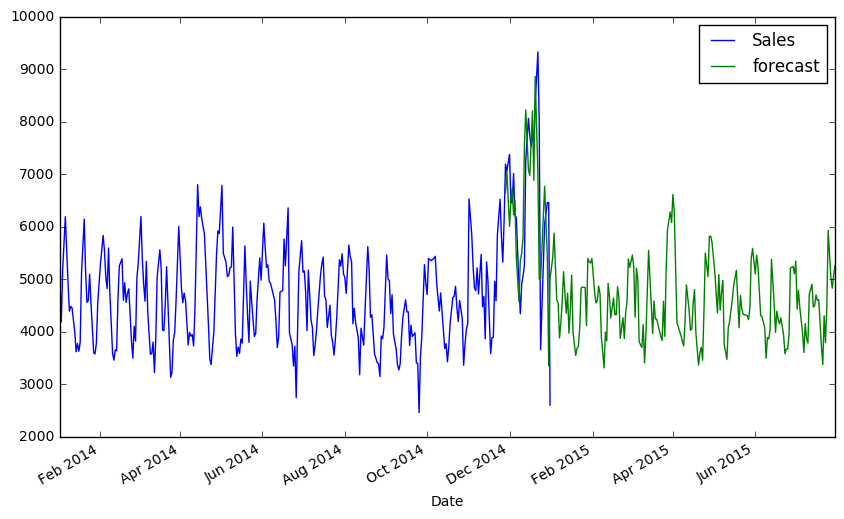

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax = store1_sales_data['2014'].plot(ax=ax)

fig = model.plot_predict(1, 201, ax=ax, plot_insample=False);

Additionally, we can revisit our diagnostics to check if our models are working well.

Let's plot the residuals and autocorrelation of residuals to test that model is working well. Are there patterns or outliers?


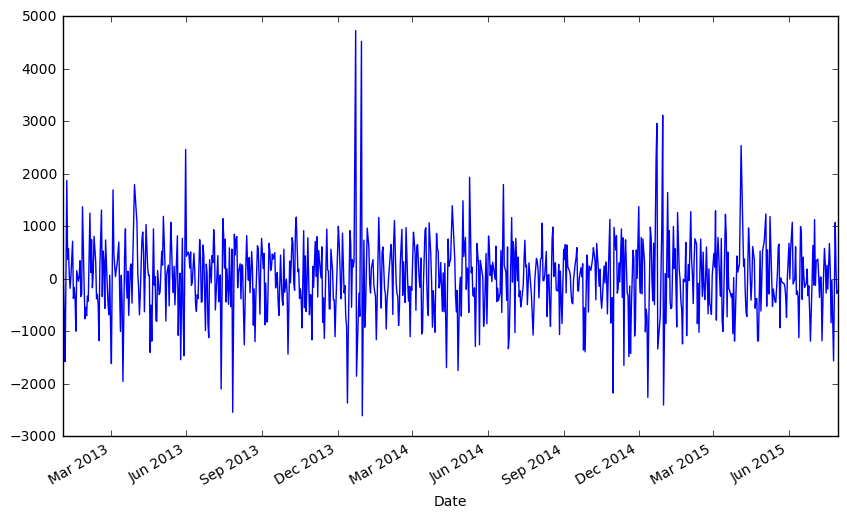

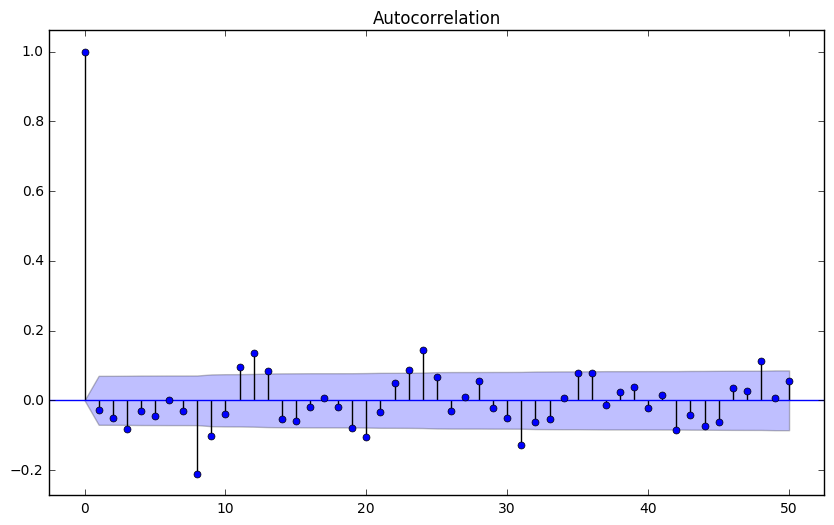

In [27]:
model.resid.plot()
plot_acf(model.resid, lags=50);

The two previous problems remain: autocorrelated residuals and large errors around the holiday period.

We can try to alter the AR model to adjust for a piece of this - increasing the lag to 7.

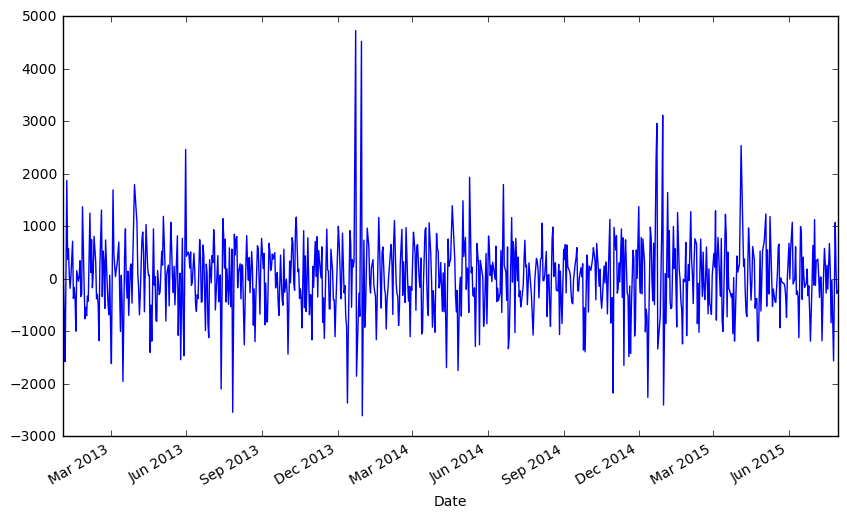

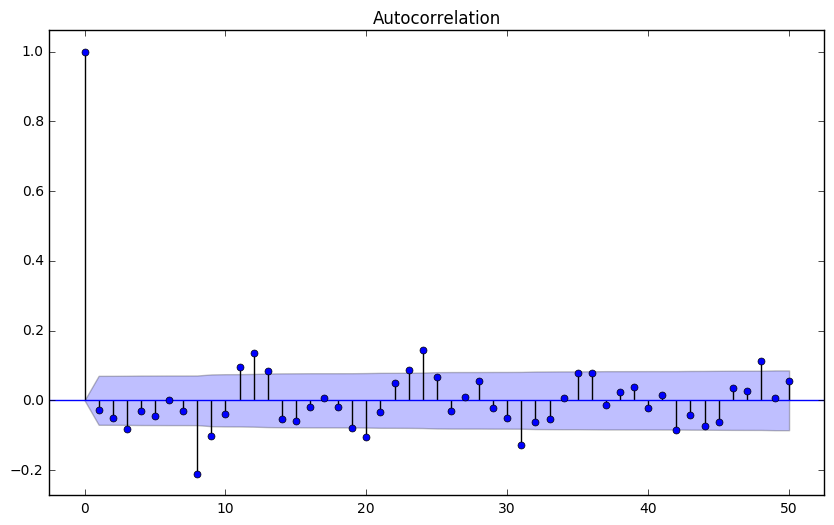

In [31]:
model = ARIMA(store1_sales_data, (7, 1, 0)).fit()
model.resid.plot()
plot_acf(model.resid, lags=50);

This removes some of the autocorrelation in the residuals, but large discrepancies still exist. However, they exist where we are breaking our model assumptions as well, which is important to keep in mind.

**Check:** What happens to our model if we increased the p, q, and d terms?



> Answer:
 - Increasing p would increase the dependency on previous values further (longer lag), but this isn't necessary past a given point.
 - Increasing q would increase the dependency of an unexpected jump at a handful of points, but we did not observe that in our autocorrelation plot.
 - Increasing d would increase differencing, but with d=1 we saw a move towards stationarity already (except at a few problematic regions). Increasing to 2 may be useful if we are saw an exponential trend, but that we did not here.



There are variants of ARIMA that will handle the seasonal aspect better, known as Seasonal ARIMA. In short, these models fit two ARIMA models, one of the daily frequency and another on the seasonal frequency (monthly or yearly, whichever the pattern may be).

Issues with seasonality could also be handled by pre-processing tricks such as detrending.

<a name="conclusion"></a>
## Recap (5 mins)
- Timeseries models use previous values to predict future values, also known as forecasting.
- AR and MA model are simple models on previous values or previous errors respectively.
- ARMA combines these two types of models to account for both local shifts (due to AR models) and abrupt changes (MA models)
- ARIMA models train ARMA models on differenced data to account for non-stationarity
- None of these models perform very well for data that has lots of random variation - for example, this isn't very useful with searches or sales that tend to increase in short bursts.

***




### ADDITIONAL RESOURCES
- [Introduction To ARIMA (Duke)](http://people.duke.edu/~rnau/411arim.htm)
- [Forecasting: Principles and Practice - ARIMA Model](https://www.otexts.org/fpp/8/1) -- **highly recommended**
- ['Everything is seasonal'](https://www.youtube.com/watch?v=IiF4-g001EQ)
- [ARIMA model overview](https://www.quantstart.com/articles/Autoregressive-Integrated-Moving-Average-ARIMA-p-d-q-Models-for-Time-Series-Analysis)
- [Time Series Analysis in Python with statsmodels](http://conference.scipy.org/proceedings/scipy2011/pdfs/statsmodels.pdf)
- [Investopedia: Stationarity](http://www.investopedia.com/articles/trading/07/stationary.asp)
- [Google Search Terms predict market movements](https://www.quantopian.com/posts/google-search-terms-predict-market-movements)